Not working yet

In [1]:
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import torch
import time

import matplotlib.pyplot as plt

from keras.utils.np_utils import to_categorical

import gym

C:\Users\Portable\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
env = gym.make('FrozenLake-v0')
nb_neurons = 60
temperature = 20
learning_rate = 0.06
gamma = 0.9

In [3]:
class brain(nn.Module):
    
    def __init__(self):
        super(brain,self).__init__()
        self.fc1 = nn.Linear(16,nb_neurons)
        self.fc2 = nn.Linear(nb_neurons,env.action_space.n)
    
    def forward(self,state):
        x = F.relu(self.fc1(state))
        q_values = self.fc2(x)
        return q_values

In [13]:
class DQN():
    def __init__(self,gamma):
        self.model=brain()
        self.gamma = gamma
        self.optimizer = optim.Adam(self.model.parameters(), lr = learning_rate)
        
    def select_action(self,state):
        probs=F.softmax(self.model(torch.Tensor(state))*temperature)
        #print(probs)
        action = probs.multinomial(4)
        #print(action)
        return action.data[0]
    
    def learn(self, current_state, next_state,reward,action):
        output = self.model(current_state)
        next_output = self.model(next_state)
        target = reward + self.gamma*(next_output.detach().max()[0])
        td_loss = F.smooth_l1_loss(output[action], target)
        #print(td_loss)
        self.optimizer.zero_grad()
        td_loss.backward()
        self.optimizer.step()
        

In [12]:
number_episodes = 30
ai = DQN(gamma)
all_reward = []

for episode in range(number_episodes):
    
    current_state = env.reset()
    #print(current_state)
    current_state = to_categorical(current_state, num_classes = 16)
    #print(ai.model(torch.Tensor(current_state)))
    cumulative_reward = 0
    for t in range(100):
        action = ai.select_action(current_state)
        next_state, reward, done, _ = env.step(np.int64(action))      
        next_state = to_categorical(next_state, num_classes = 16)
        
        ai.learn(torch.Tensor(current_state),torch.Tensor(next_state),reward,action)
        cumulative_reward+=reward 
        
        if done:
            break
        current_state = next_state
    all_reward.append(cumulative_reward)

C:\Users\Portable\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  
C:\Users\Portable\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


In [6]:
learning = []
y = []
batch_size = 200
for i in range(0,len(all_reward),batch_size):
    learning.append(sum(all_reward[i:i+batch_size])/batch_size)
    y.append(i)

Text(0.5,1,'Evolution of the reward')

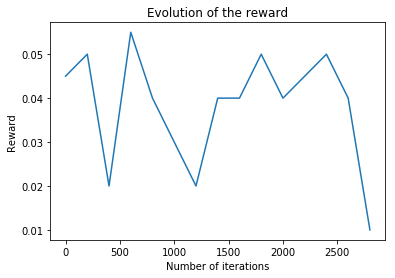

In [7]:
plt.plot(y,learning)
plt.ylabel('Reward')
plt.xlabel('Number of iterations')
plt.title('Evolution of the reward')

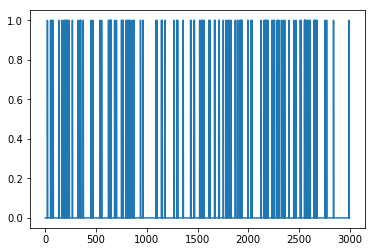

In [8]:
plt.plot(all_reward)